<h1 style="text-align:center;">Cell Catcher <span style="text-align:center;font-size: 0.5em;">0.2.1</span></h1>
<h2 style="text-align:center;">CeMiA Toolkit <i style="font-size: 0.5em;">0.6.0</i></h2>
<h3 style="text-align:center;">Kashatus Lab @ UVA</h3>

# Welcome to Cell Catcher
#### Cell Catcher is part of CeMiA toolkit that enables you to separate individual cells from fluorescently labeled multi-cell images.
This Jupyter notebook provides you with step-by-step directions to separate individual cells from multi-cell images.

## 1) Importing necessary libraries
Please check the requirements in the Readme file.

##### Just run the following block of code, you are not expected to enter any data here.

In [10]:
#Base Libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import cv2
import shutil


#Interaction
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Checkbox, FloatSlider, Dropdown
from IPython.display import clear_output

#Core Functions
import cemia55s as cemia

layout = widgets.Layout(width='800px')

## 2) Locate and Sample Files

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">Instructions</span></summary>
    
#### <span style="color:red;">Interact with the code: </span> Please enter the relative address of the folder that contains your images. 

#### <span style="color:red;">Examples: </span>
* Use . if the images are in the same folder as this file
* If the folder of the images is named "test" and is located on the upper level of the current folder, the address would be ../test (Mac)

#### <span style="color:red;">Note: </span>
* It is preferred to have the folder of your images in the same folder as the current file that you are running
* You should press enter after you enetered the address in the box.
</details>

In [2]:
address,file_list = cemia.address()

Where are the files located?

test2


### How many files to sample?

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">Instructions</span></summary>
    

#### You should enter the maximum number of the sample files that you want to initiallay analyze for parameter tuning purposes.
##### Just sample a reasonable number of files to 

#### <span style="color:red;">Note:</span>
* The number of sampled images may be equal or lower than the number your enter. The maximum indicated number is the total number of the files in that folder, which may or may not be valid images.

#### <span style="color:red;">Interaction required</span>
</details>

In [3]:
how_many = cemia.how_many(file_list)


How many files to sample? (If possile)
Please enter a valid integer value below 5
3


##### Here we  randomly sample some images for parameter tuning purposes
##### Just run the following block of code, you are not expected to enter any data here.

In [4]:
random_files = cemia.random_files(address,file_list,how_many)


These files were validated and selected:

 ['r03c05f01p01multi_channel.tiff']


## 3) Finding and isolating individual cells in the sample images
##### Just run the following block of code, you are not expected to enter any data here.

In [5]:
threshold_pro = ['Assisted Automatic (Pro)']
abspath = os.path.join(address,'temp')

##### The next block of code is designed to help you to identify individual nuclei in the image. While in most cases the default values will do a good job, but in some cases you may find it useful to tune the values of different parameters, and find a combination that works best for your dataset.

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">List of parameters you are adjusting here</span></summary>

<p><b>Correct Nucleus:</b> This feature tries to reconstruct the shape of the poorly illuminated nuclei in the image.</p>
<p><b>Diffused Background:</b> In rare cases that your images suffer from extremely low contrast, this option may help.</p>
<p>Make sure your settings work good on all your sample images by selecting different images from the dropdown menu.</p>
</details>

In [6]:
layout = widgets.Layout(width='800px')
nuc_mask = []

#List of Parameters
params = cemia.catcher_initial_params

@interact(file=random_files, Intensity_Threshold=IntSlider(min=0,max=100,step=1,value=10,continuous_update=False,layout=layout),
          Size_Threshold=IntSlider(min=500,max=5000,step=250,value=1000,continuous_update=False,layout=layout),
          correct=Checkbox(value=True,description='Correct Nucleus',layout = layout),
          diffuse=Checkbox(value=False,description='Diffused background',layout = layout))

def segment_nucleus(file,Intensity_Threshold, Size_Threshold, correct, diffuse):

    fullpath_input = os.path.join(address, file)
    abspath = os.path.join(address, 'cell_catcher')
    
    namestring = file[:file.rfind('.')] + '.tif'
    
    #Update parameters, based on user interaction
    params['Intensity_threshold'].append(Intensity_Threshold)
    params['Size_threshold'].append(Size_Threshold)
    params['diffused_bg'].append(diffuse)
    params['nuc_correction'].append(correct)

    try:        
        mask = cemia.nucleus_filtering(fullpath_input, abspath, Intensity_Threshold, Size_Threshold,True,correct, diffused=diffuse)
        nuc_mask.append(mask)
    except:
        print('{} is not a valid image file, trying the next file.'.format(file))
        pass

print('You can now go to next step!')


interactive(children=(Dropdown(description='file', options=('r03c05f01p01multi_channel.tiff',), value='r03c05f…

You can now go to next step!


##### The next block of code is designed to help you to identify and separate individual cells in the image. While in most cases the default values will do a good job, but in some cases you may find it useful to tune the values of different parameters, and find a combination that works best for your dataset.

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">List of parameters you are adjusting here</span></summary>

<p><b>Threshold:</b> The intensity threshold for mitochondria</p>
<p><b>Neighborhood:</b> The radial distance around the nuclei to search for mitochondria. (to identify ghost cells)</p>
<p><b>Empty Cell Threshold:</b> The minimum accepatble amount of mitochondrial content around a cell (to identify ghost cells)</p>
<p><b>Separate Cells:</b> This item should be checked in order to separate the individual cells in the image.</p>

</details>

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">Additional notes</span></summary>


* It is better to first check all the images ("Separate Cells" switched off), and once you are happy with your set of parameters, then activate the "Separate Cells", and repeat the process for each cell in your sample data.
* Every time you select a new cell, while the segment cell is checked, it will automatically start to segment the cells in the image, which may take some time. Once segmentation is done, the segmented cells will show up.

</details>

In [7]:
@interact(file=random_files, Threshold=IntSlider(min=5,max=100,step=2,value=65,continuous_update=False,layout=layout),
          dilation=IntSlider(min=35,max=100,step=5,value=45,continuous_update=False,description='Neighborhood',layout=layout),
          empty_cell_threshold=IntSlider(min=0,max=250000,step=2500,value=25000,continuous_update=False,description='Empty Cell Thresh',layout=layout),
          showimg=Checkbox(value=False,description='Separate Cells',layout = layout),
          correct=Checkbox(value=True,description='Remove Ghost Cells',layout = layout))

def segment_cell(file,Threshold, dilation,empty_cell_threshold,showimg, correct):

    fullpath_input = os.path.join(address, file)
    abspath = os.path.join(address, 'cell_catcher_temp')
    
    namestring = file[:file.rfind('.')] + '.tif'
    
    #Updating parameters based on user interaction
    params['mito_threshold'].append(Threshold)
    params['empty_cell_thresh'].append(empty_cell_threshold)

    try:
        mask_blue=cemia.auto_segmentation(fullpath_input, abspath, namestring,Threshold,showimg,dilation, correct, params['Intensity_threshold'][-1], params['Size_threshold'][-1],params['empty_cell_thresh'][-1], hide=False,nuc_correct=False,diffused=params['diffused_bg'][-1])

    except:
        print('{} is not a valid image file, try another file.'.format(file))
        pass


    params['correct_cells'].append(correct)

#print('Done! Go to next step.')


interactive(children=(Dropdown(description='file', options=('r03c05f01p01multi_channel.tiff',), value='r03c05f…

In [8]:
print('The following settings will be used to analyze all the images!')
print('**************************************************************')
params_pd = {}
for k in params:
    try:
        params_pd[k] = params[k][-1]
        print(f'{k}: {params_pd[k]}')
    except:
        pass
    
params_pd = pd.DataFrame(params_pd, index=[0])
params_pd.to_csv(os.path.join(address ,'cell_catcher_params.csv'), index=False)


The following settings will be used to analyze all the images!
**************************************************************
Intensity_threshold: 10
Size_threshold: 1000
correct_cells: True
neighorhood: 45
mito_threshold: 65
empty_cell_thresh: 25000
nuc_correction: True
diffused_bg: False


## 4) Processing all the cells
##### Just run this block of code, and then go and enjoy your time. Running this block of code may take few hours depending on the number of images that you have.

.DS_Store
.DS_Store is not a valid image file, trying the next file.
r03c05f01p01multi_channel.tiff

Please wait...
Number of Nuclei:  27
Linking 664 Mitochondria to 27 Cells


/Users/ali/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/ali/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)



Number of mitochondria with obvious links to nuclei:  70
Assigning mitochondria with obvious links to respective nuclei...

Number of mitochondria with less obvious links:  0
Finding the best nuclei to assign mitochondria with less obvious links...

Number of floating mitochondria:  594
Assigning floating mitochondria to the most probable nuclei...

Number of mitochondria common between multiple nuclei:  0
Finding the best nuclei to assign mitochondria with multiple links
Cell 1 QC: Bad
Cell 2 QC: Good

test2/output/to_analyze/r03c05f01p01multi_channel_cell2_1024.tif
Cell 3 QC: Good
test2/output/to_analyze/r03c05f01p01multi_channel_cell3_1024.tif
Cell 4 QC: Good
test2/output/to_analyze/r03c05f01p01multi_channel_cell4_1024.tif
Cell 5 QC: Good
test2/output/to_analyze/r03c05f01p01multi_channel_cell5_1024.tif
Cell 6 QC: Good
test2/output/to_analyze/r03c05f01p01multi_channel_cell6_1024.tif
Cell 7 QC: Good
test2/output/to_analyze/r03c05f01p01multi_channel_cell7_1024.tif
Cell 8 QC: Good
test

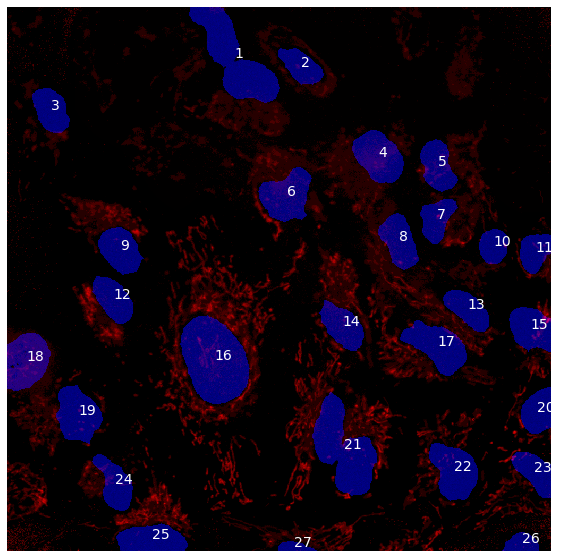

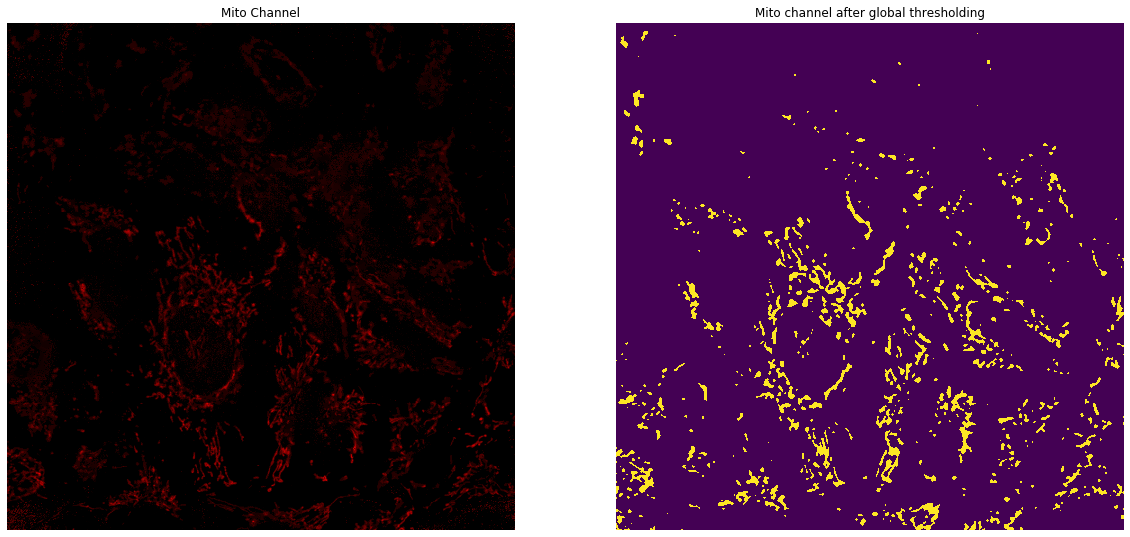

In [9]:
try:
    os.makedirs(os.path.join(address, 'output'))
except FileExistsError:
    pass

cell_list = os.listdir(address)

for file in file_list:

    fullpath_input = os.path.join(address, file)
    abspath = os.path.join(address, 'output')
    namestring = file[:file.rfind('.')] + '.tif'
    print(file)

    try:
        cemia.auto_segmentation(fullpath_input, abspath, namestring,params['mito_threshold'][-1],True,params['neighorhood'][-1], params['correct_cells'][-1], params['Intensity_threshold'][-1], params['Size_threshold'][-1], params['empty_cell_thresh'][-1], hide=True, nuc_correct=False, diffused=params['diffused_bg'][-1])
    except:
        print('{} is not a valid image file, trying the next file.'.format(file))
        pass


print('Done with cutting cells!\nGoing to the filtering.\n')

## Optional Step: Remove Cell Catcher Temp folders
#### If you want to delete the temporary folders created by Cell Catcher, please run the following cell. This is the folder that contains the cells that you isolated when you were experimenting with Cell Catcher

In [14]:
try:
    shutil.rmtree(os.path.join(address,'cell_catcher_temp'))
except:
    pass

# The End!